# Natural Language Preprocessing and Word Vectors

In this notebook, we clean up a dataset of natural language data (books from Project Gutenberg) and use word2vec to embed the language in word vectors.

**N.B.:** Some, all or none of these preprocessing steps may be helpful to a given downstream application.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/natural_language_preprocessing.ipynb)

#### Load dependencies

In [2]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\JL\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load Data

In [3]:
# The dataset we used in this notebook is a small corpus of out-of-copyright books from Project Gutenberg.
from nltk.corpus import gutenberg

In [4]:
# The number of books (documents)
len(gutenberg.fileids())

18

In [5]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
len(gutenberg.words())

2621613

In [7]:
# To tokenize the corpus into a list of sentences
gberg_sent_tokens = sent_tokenize(gutenberg.raw())

In [8]:
gberg_sent_tokens[1]

"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period."

In [9]:
# we can further tokenize this sentence down to the word level
word_tokenize(gberg_sent_tokens[1])

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'s",
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

In [10]:
# 15th word in a second sentence
word_tokenize(gberg_sent_tokens[1])[14]

'father'

In [11]:
# a convenient method that handles newlines, as well as tokenizing sentences and words in one shot
gberg_sents = gutenberg.sents()

In [12]:
gberg_sents[0:2]

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'], ['VOLUME', 'I']]

In [13]:
# the first actual sentence of Emma is now on its own as the fourth element of gberg_sents
gberg_sents[4][14]

'father'

#### Iteratively preprocess a sentence

##### a tokenized sentence:

In [14]:
gberg_sents[4]

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### to lowercase:

In [15]:
[w.lower() for w in gberg_sents[4]]

['she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### remove stopwords and punctuation:

In [16]:
stpwrds = stopwords.words('english') + list(string.punctuation)

In [17]:
stpwrds

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
[w.lower() for w in gberg_sents[4] if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period']

##### stem words:

In [19]:
stemmer = PorterStemmer()

In [20]:
[stemmer.stem(w.lower()) for w in gberg_sents[4]
 if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughter',
 'affection',
 'indulg',
 'father',
 'consequ',
 'sister',
 'marriag',
 'mistress',
 'hous',
 'earli',
 'period']

##### handle bigram (e.g.,New York) collocations:

In [21]:
# train a “detector” to identify how often any given pair of words occurs together in our corpus
phrases = Phrases(gberg_sents)

In [22]:
bigram = Phraser(phrases) # create a more efficient Phraser object for transforming sentences

In [23]:
# output a dictionary of the count and score of each bigram
bigram.phrasegrams

{'two_daughters': 11.966813731181547,
 'her_sister': 17.7960829227865,
 "'_s": 31.066242737744524,
 'very_early': 11.01214147275924,
 'Her_mother': 13.529425062715127,
 'long_ago': 63.22343628984789,
 'more_than': 29.023584433996874,
 'had_been': 22.306024648925288,
 'an_excellent': 39.063874851750626,
 'Miss_Taylor': 453.75918026073305,
 'very_fond': 24.134280468850747,
 'passed_away': 12.35053642325912,
 'too_much': 31.376002029426687,
 'did_not': 11.72841621714281,
 'any_means': 14.096964108090186,
 'wedding_-': 17.4695197740113,
 'Her_father': 13.129571562488772,
 'after_dinner': 21.528548116881705,
 'self_-': 47.79018053120332,
 'sixteen_years': 107.0461671612265,
 'five_years': 40.128755673408115,
 'years_old': 54.735425236061104,
 'seven_years': 52.59411150244507,
 'each_other': 79.4168405322873,
 'a_mile': 12.783091600264584,
 'must_be': 10.229989650632808,
 'difference_between': 220.52537305244678,
 'could_not': 10.870983286982371,
 'having_been': 11.53801833156938,
 'miles_of

In [24]:
# Simple bigram example
# Let’s tokenize a short sentence by using the split() method on a string of characters wherever there’s a space
tokenized_sentence = "Jon lives in New York City".split()

In [25]:
tokenized_sentence

['Jon', 'lives', 'in', 'New', 'York', 'City']

In [26]:
bigram[tokenized_sentence]

['Jon', 'lives', 'in', 'New_York', 'City']

## Preprocess the Full corpus

Removing capitalization and punctuation from Project Gutenberg
corpus

In [27]:
# as in Maas et al. (2001):
# - leave in stop words ("indicative of sentiment")
# - no stemming ("model learns similar representations of words of the same stem when data suggests it")
lower_sents = []
for s in gberg_sents:
    lower_sents.append([w.lower() for w in s if w.lower()
                        not in list(string.punctuation)])

In [28]:
lower_sents[0:5]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period']]

In [29]:
# we created our gensim lower_bigram object in a single line by chaining the Phrases() and Phraser() methods together
lower_bigram = Phraser(Phrases(lower_sents))

In [ ]:
lower_bigram.phrasegrams # miss taylor, mr woodhouse, mr weston

In [ ]:
# with optional arguments
lower_bigram = Phraser(Phrases(lower_sents,
                               min_count=32, threshold=64))
lower_bigram.phrasegrams

Creating a “clean” corpus that includes bigrams

In [32]:
clean_sents = []
for s in lower_sents:
    clean_sents.append(lower_bigram[s])

In [33]:
clean_sents[6]

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

## Run word2vec

In [39]:
# max_vocab_size can be used instead of min_count (which has increased here)
model = Word2Vec(sentences=clean_sents, vector_size=64,
                 sg=1, window=10, epochs=5,
                 min_count=10, workers=4)
model.save('clean_gutenberg_model.w2v')

#### Explore model

In [40]:
# Upload "clean_guttenberg_model.w2v"
# skip re-training the model with the next line:
model = gensim.models.Word2Vec.load('clean_gutenberg_model.w2v')

In [41]:
# 64 dimensional vector
model.wv['dog']

array([-0.4081911 , -0.20401837, -0.12628075, -0.05416077,  0.26510674,
       -0.17649429,  0.01088718,  0.14090064, -0.25193948,  0.4471024 ,
       -0.02727524, -0.1253992 , -0.22924401, -0.24327518, -0.23137133,
       -0.37040186,  0.21884792,  0.33565503, -0.4888107 ,  0.11813794,
        0.32214525,  0.45588464,  0.48107997, -0.21744157, -0.13726014,
        0.2984098 , -0.4083975 ,  0.24696778,  0.5099553 , -0.25692332,
       -0.02003153, -0.08580012, -0.08220891, -0.15324073,  0.03143491,
       -0.20332326,  0.4918123 , -0.11059658,  0.17251803,  0.28138605,
       -0.16148609,  0.02482043, -0.5128453 , -0.50178266,  0.3954742 ,
       -0.09777193, -0.38867566, -0.22225307, -0.3258133 ,  0.3240435 ,
        0.03766909,  0.22139783,  0.35263446, -0.12312216,  0.35987145,
        0.36468813,  0.18062122,  0.34543192,  0.00187585,  0.3423723 ,
       -0.11415949, -0.03092173, -0.43742034, -0.18457554], dtype=float32)

In [42]:
len(model.wv['dog'])

64

In [43]:
model.wv.most_similar('dog', topn=3)

[('puppy', 0.7970860004425049),
 ('pet', 0.7906566262245178),
 ('cage', 0.755458414554596)]

In [44]:
model.wv.most_similar('eat', topn=3)

[('bread', 0.8599131107330322),
 ('drink', 0.812942624092102),
 ('meat', 0.7550645470619202)]

In [45]:
model.wv.most_similar('day', topn=3)

[('morning', 0.7677834033966064),
 ('night', 0.7550985813140869),
 ('week', 0.7525852918624878)]

In [46]:
model.wv.most_similar('father', topn=3)

[('mother', 0.8024529814720154),
 ('sister', 0.7305725812911987),
 ('brother', 0.7280907034873962)]

In [48]:
model.wv.most_similar('ma_am', topn=3)

[('betty', 0.8525012731552124),
 ('m_sure', 0.8476787805557251),
 ('mamma', 0.8300531506538391)]

In [49]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

In [50]:
model.wv.similarity('father', 'dog')

0.52255905

In [51]:
# father - man + woman
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])

[('mother', 0.7764347791671753),
 ('wife', 0.7588748931884766),
 ('sister', 0.7586783170700073),
 ('daughter', 0.7506245374679565),
 ('husband', 0.725021243095398),
 ('isaac', 0.7068718075752258),
 ('tamar', 0.6814970374107361),
 ('daughters', 0.6788557767868042),
 ('sarah', 0.6775580048561096),
 ('rebekah', 0.6643305420875549)]

In [52]:
# husband - man + woman
model.wv.most_similar(positive=['husband', 'woman'], negative=['man'])

[('wife', 0.7172253727912903),
 ('daughter', 0.6936959028244019),
 ('sister', 0.6855185627937317),
 ('mother', 0.6728118062019348),
 ('maid', 0.6583749055862427),
 ('child', 0.6517794132232666),
 ('conceived', 0.6367018222808838),
 ('elder', 0.6221467852592468),
 ('harlot', 0.6205224990844727),
 ('nurse', 0.6038546562194824)]

#### Visualise

In [53]:
coords_df = pd.read_csv('clean_gutenberg_tsne.csv')
coords_df.head()

,x,y,token
0,62.494060,8.023034,emma
1,8.142986,33.342200,by
2,62.507140,10.078477,jane
3,12.477635,17.998343,volume
4,25.736960,30.876250,i


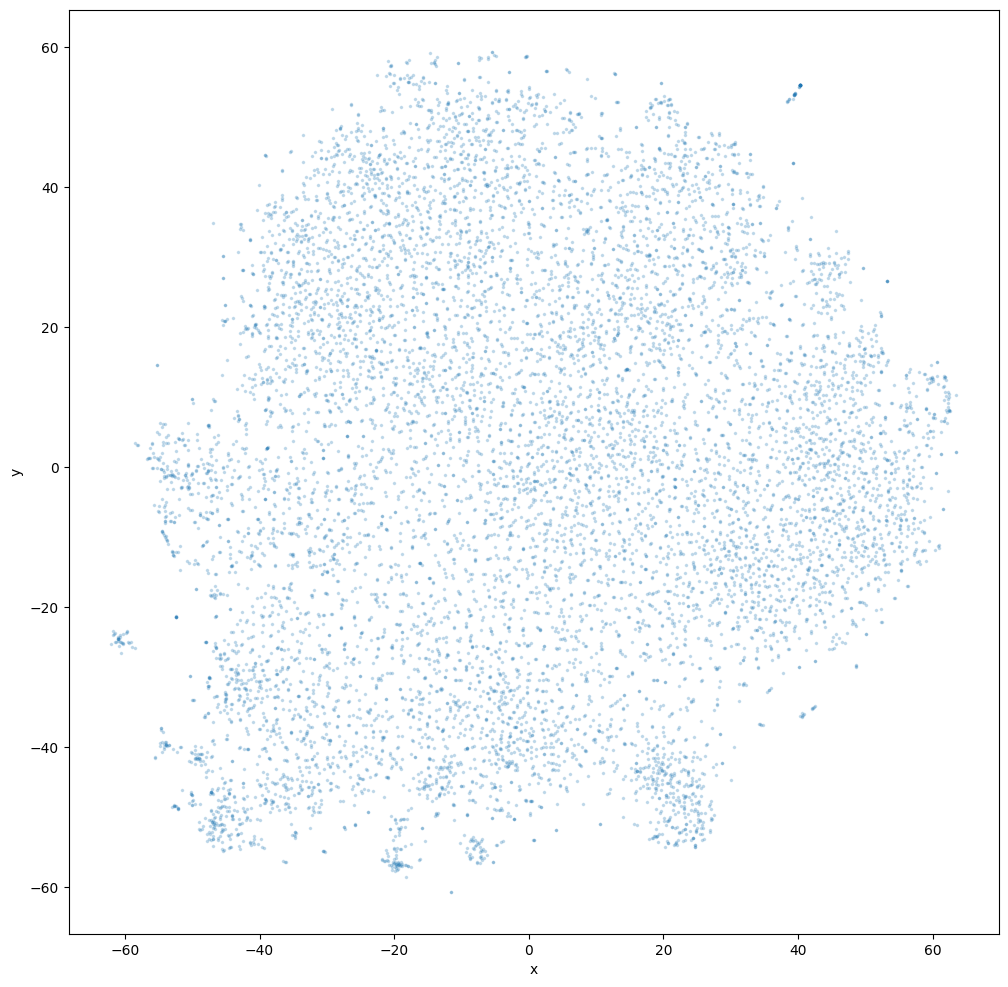

In [70]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12),
                           marker='.', s=10, alpha=0.2)

In [81]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LabelSet

# Ensure Bokeh plots are displayed inline in the notebook
output_notebook()

# Sample a subset of the data
subset_df = coords_df.sample(n=100)  # instead of 5000

# Create a new figure
p = figure(width=800, height=800, tools="pan,box_zoom,reset,save", title="2D Word Vectors")

# Create a ColumnDataSource from the subset dataframe
source = ColumnDataSource(subset_df)

# Plot the points
p.circle(x='x', y='y', size=5, source=source, line_color="navy", fill_color="orange", fill_alpha=0.5)

# Add text labels to the points without the render_mode attribute
labels = LabelSet(x='x', y='y', text='token', level='glyph', x_offset=5, y_offset=5, source=source)
p.add_layout(labels)

# Display the plot
show(p)